In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_palette("tab10")

import seaborn as sns
import pickle
import os
from notify_run import Notify

In [34]:
notify = Notify()

n_dimensional_benchmark = ['Ackley', 'Rosenbrock', 'Griewank', 'Rastrigrin', 'Schwefel', 'Ellipse', 'Cigar', 'Tablet', 'Sphere']
renames = {
    'mupluslambda': 'plus selection',
    'roulette_wheel': 'roulette wheel selection',
    'single_elitist_rws': 'elitist roulette wheel selection',
    'tournament': 'tournament selection',
    'single_elitist_tournament': 'elitist tournament selection',
    'no_replacement_tournament': 'tournament selection without replacement'
    
}

In [3]:
#verry important
os.chdir(r"C:/Users/nieli/Documents/uva/thesis/code/")
print(os.getcwd())

C:\Users\nieli\Documents\uva\thesis\code


In [4]:
results_folder = 'PPA/results/final/results-2021-07-01_14-35-06/'
# results_folder = 'PPA/results/5mljn-evals/'


In [5]:
df = pd.DataFrame(columns=['run_n', 'benchmark','selection_method','best_final_objval','best_objval','theoretical_optimum','dimensions'])

i = 0
for filename in os.listdir(results_folder):
    i+=1
    if i%500 == 0:
        print(f'total of {i/500*500} files read')
    file = pickle.load(open(results_folder+filename,"rb"))
        
    
    df = df.append({
        'run_n':file.run_n,
        'benchmark':file.benchmark_name, 
        'selection_method':file.survivor_selection_name,
        'best_final_objval': min(individual.objective_value for individual in file.parent_population), #this is the best object value at the end of the run
        'best_objval': file.best_objval_during_run.objective_value,   #this is the best obj value recorded during the run
        'theoretical_optimum': file.benchmark_optimum,
        'dimensions': file.benchmark_dimensions,
        'diplay_name': f"{file.benchmark_name}-{file.benchmark_dimensions:03d}D"
    }, ignore_index=True)
# df.loc[df['selection_method'] == 'single_elitist_tournament','selection_method'] = 'tour_elite'
# df.loc[df['selection_method'] == 'no_replacement_tournament','selection_method'] = 'tour_no_replace'

df['error'] = abs(df['best_objval'] - df['theoretical_optimum'])
# df['benchmark'] = df.benchmark.str.replace("20", "d").str.replace("100", "f").str.replace("2", "a").str.replace("50", "e").str.replace("5", "b").str.replace("10", "c")

df = df.sort_values(by="benchmark")
df = df.astype({'theoretical_optimum':float,'error':float})
notify.send('Done reading all files')

total of 500.0 files read
total of 1000.0 files read
total of 1500.0 files read
total of 2000.0 files read
total of 2500.0 files read
total of 3000.0 files read
total of 3500.0 files read
total of 4000.0 files read
total of 4500.0 files read
total of 5000.0 files read
total of 5500.0 files read
total of 6000.0 files read
total of 6500.0 files read
total of 7000.0 files read


In [6]:
# group by selectionmethod, benchmark and dimension, and find the median performance;
# next find the run number associated with the median and store it in the same data set
median_data = df.groupby(['selection_method', 'benchmark','dimensions']).median('error').reset_index()
median_data['run_n'] = None
for index, row in median_data.iterrows():
    run_n = df[(row['selection_method'] == df['selection_method']) & (row['dimensions'] == df['dimensions']) & (row['error'] == df['error'])].head(1).run_n
    median_data.loc[index, 'run_n'] = int(run_n)


In [7]:
# we now select the rows containing selection methods for which heritage analysis can be stored
heritage_df = median_data[median_data['selection_method'].isin(['mupluslambda', 'tournament', 'single_elitist_tournament',
                                     'no_replacement_tournament', 'roulette_wheel','single_elitist_rws'])]

In [32]:
# sort values according to a custom order
selection_method_order = ['mupluslambda','roulette_wheel','single_elitist_rws','tournament','single_elitist_tournament','no_replacement_tournament']
heritage_df['selection_method'] = pd.Categorical(heritage_df['selection_method'], selection_method_order)
heritage_df = heritage_df.sort_values('selection_method')

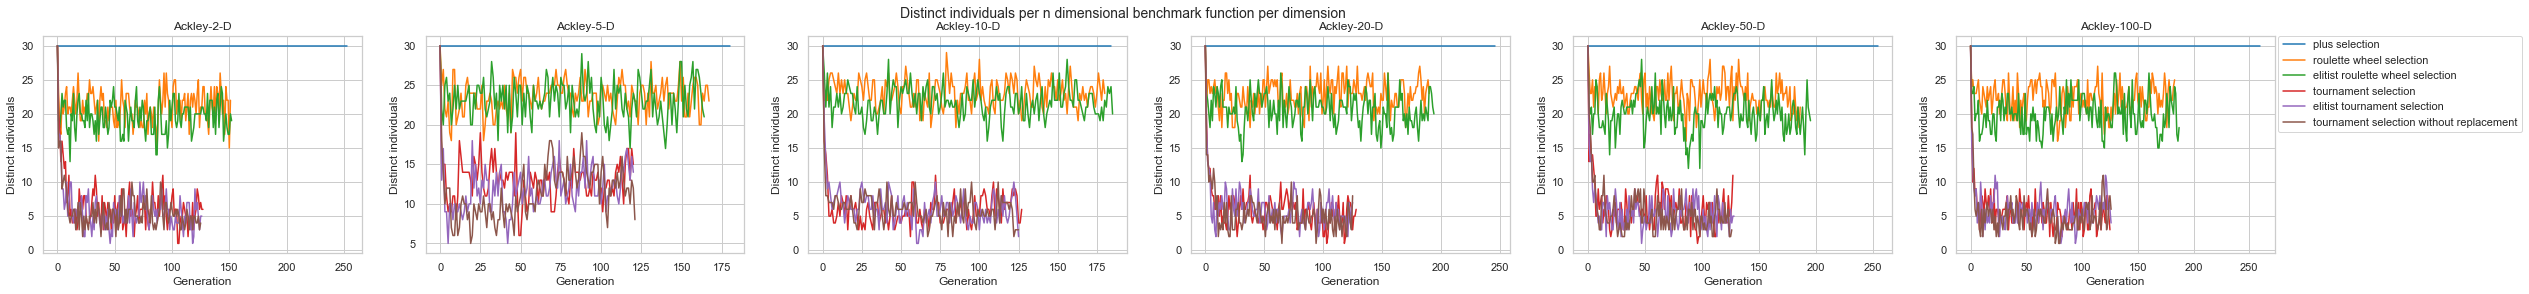

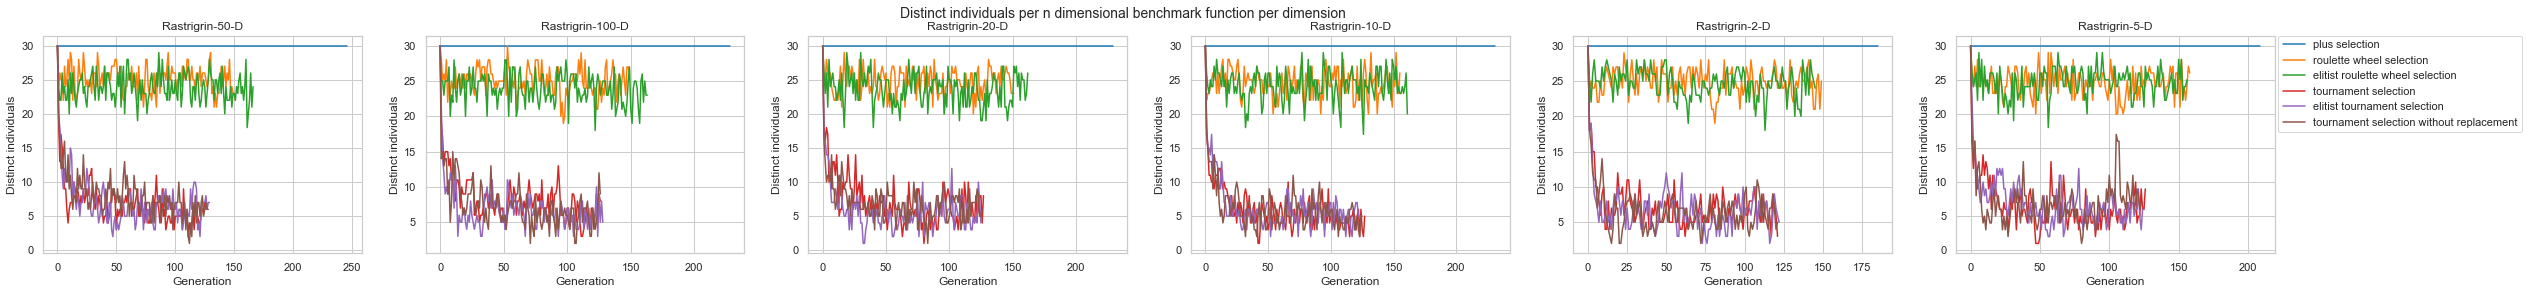

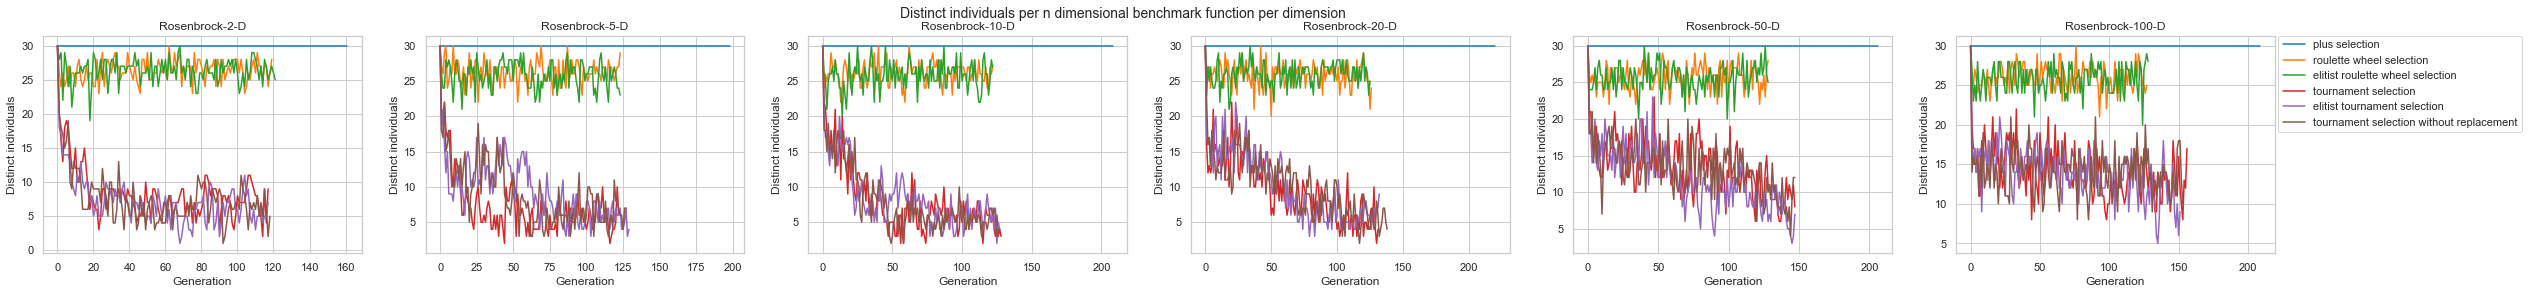

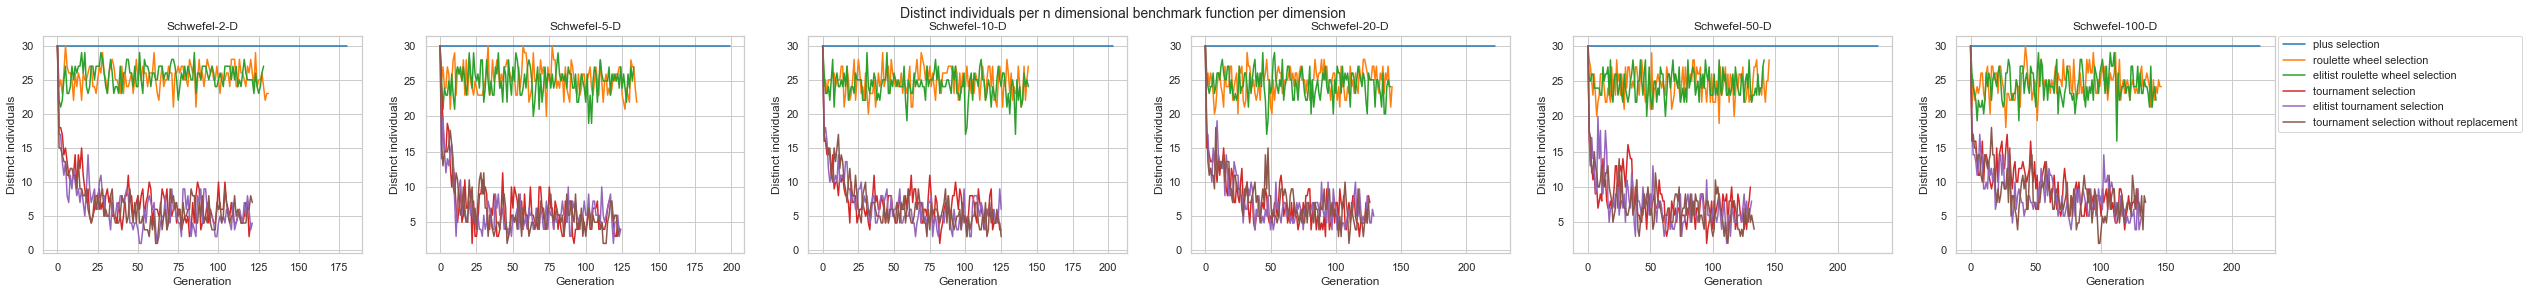

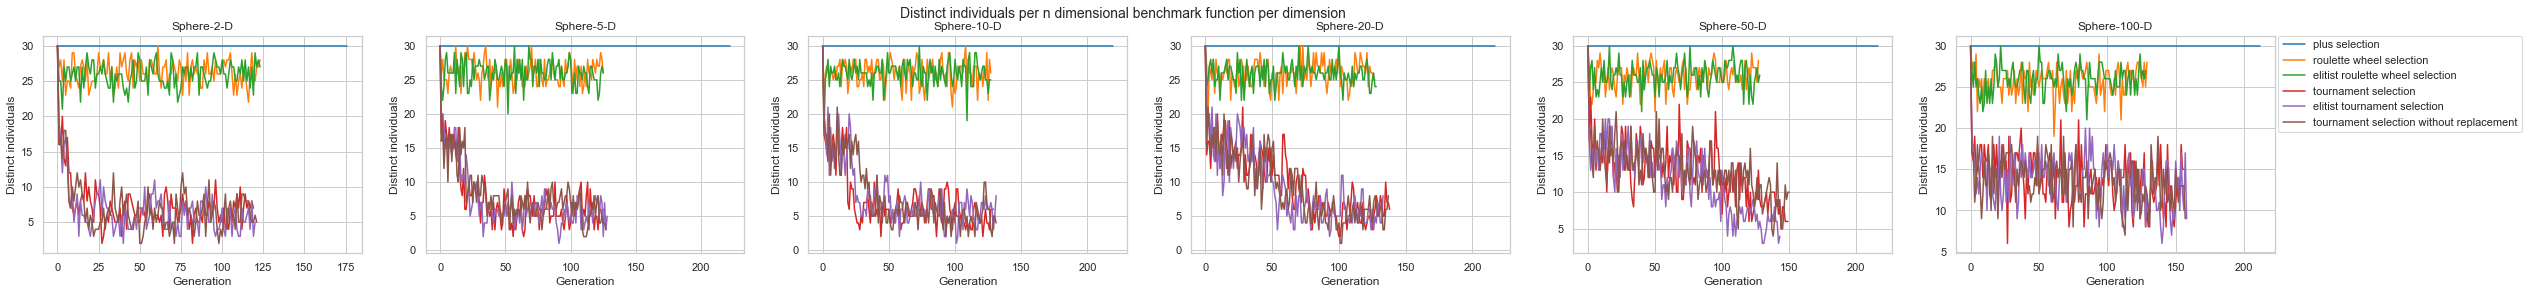

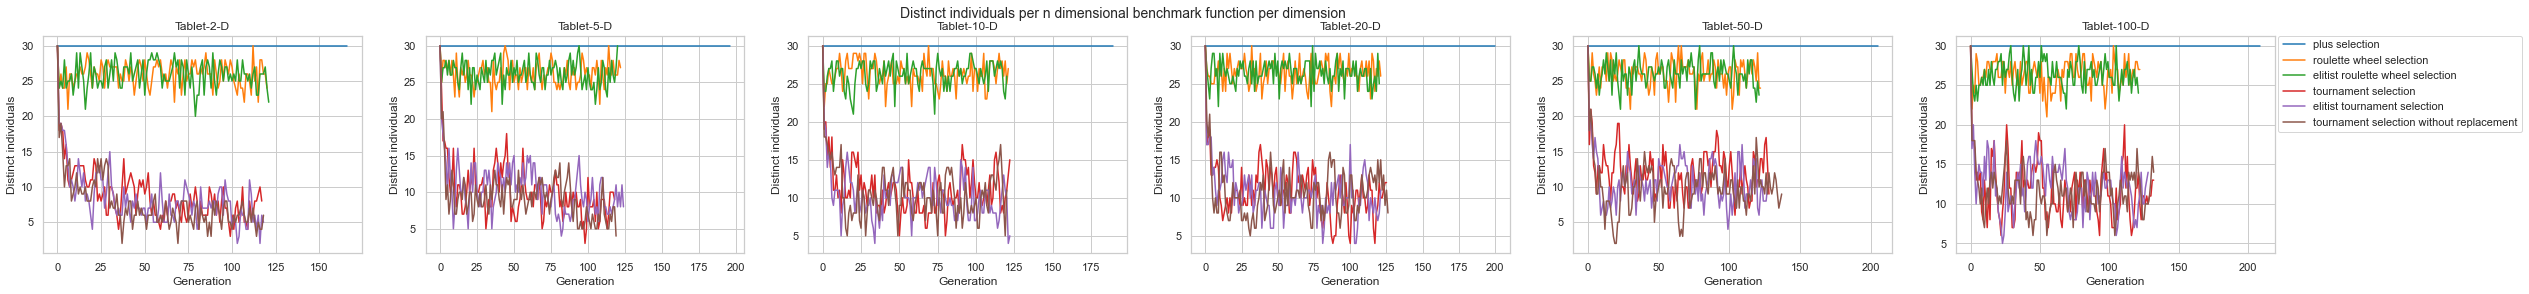

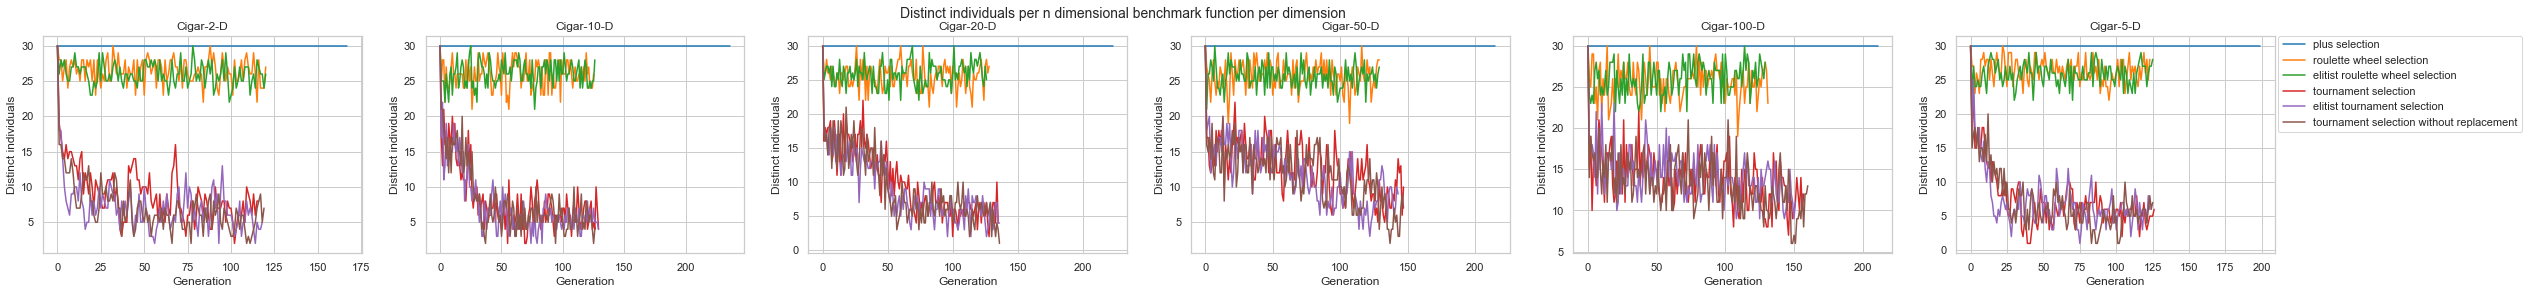

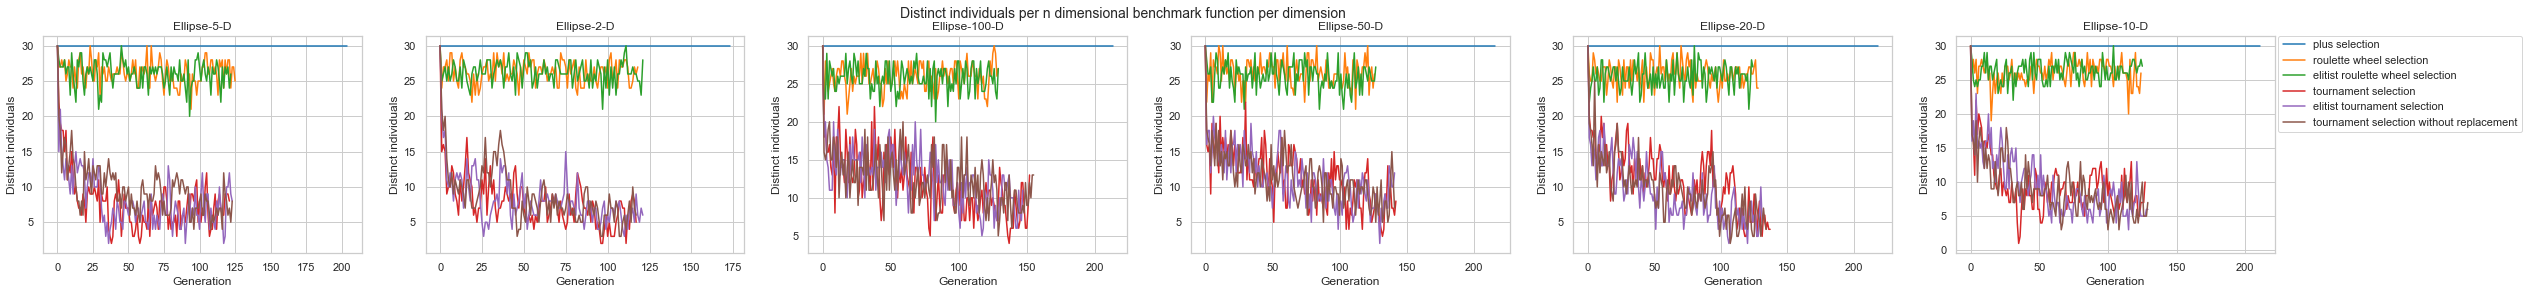

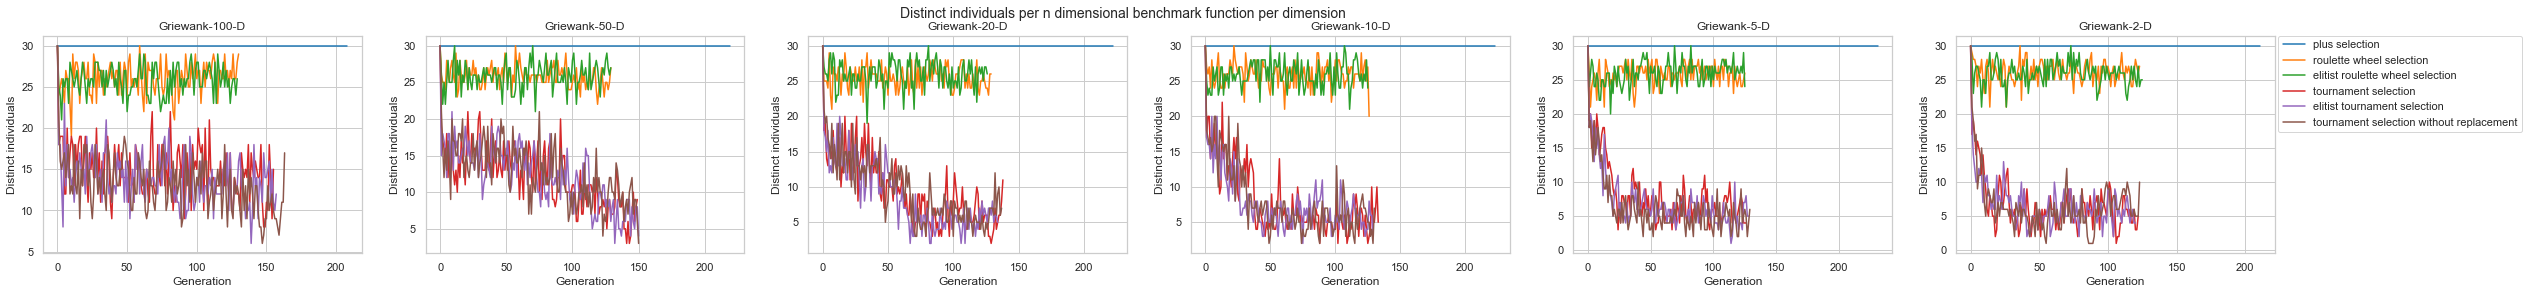

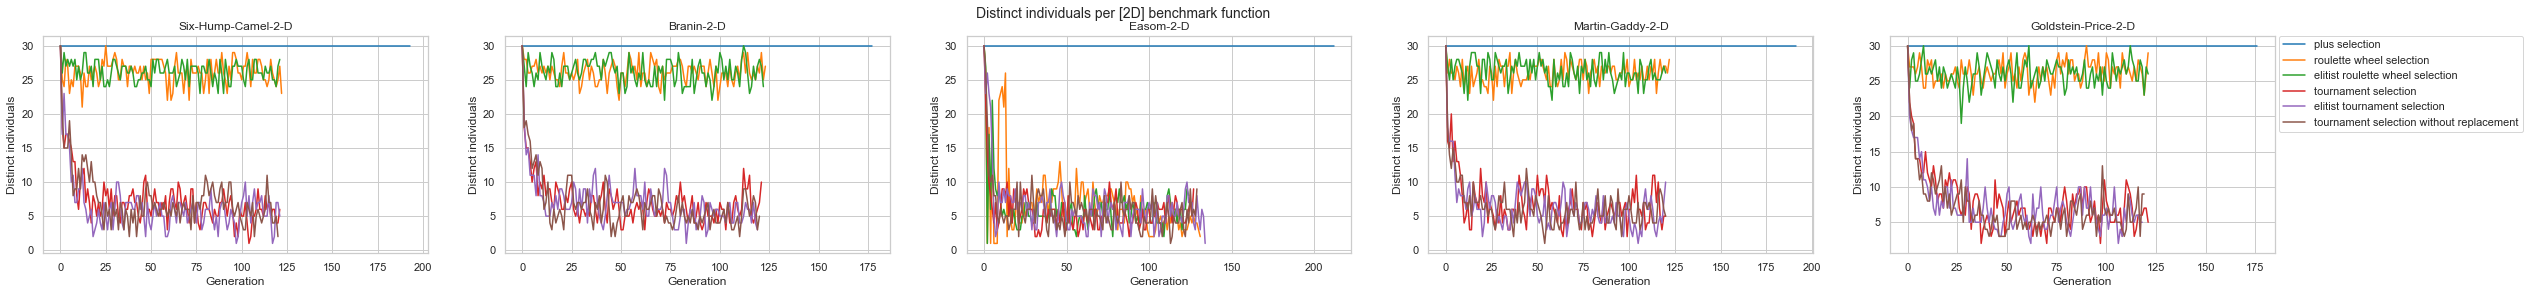

In [35]:
#now we start looping over the benchmark function instances and per benchmark function instance we will present the number of offspring

for benchmark in heritage_df[heritage_df['benchmark'].isin(n_dimensional_benchmark)]['benchmark'].unique():
    benchmark_df = heritage_df[heritage_df['benchmark'] == benchmark]
    unique_dimensions = benchmark_df['dimensions'].unique()
    fig, axs =plt.subplots(1,len(unique_dimensions), figsize=(40,4))
    plt.suptitle('Distinct individuals per n dimensional benchmark function per dimension', fontsize=14)
    i = 0
    for dim in unique_dimensions:
        benchmark_instance_df = benchmark_df[benchmark_df['dimensions'] == dim]
                
        for selection_method in benchmark_instance_df['selection_method'].unique():
            bfi_selection_method = benchmark_instance_df[benchmark_instance_df['selection_method'] == selection_method]
            run_n = bfi_selection_method.run_n
        
            # check if it is a nd function, if so, change the name
            if benchmark in n_dimensional_benchmark:
                heritage_data = pickle.load(open(f"{results_folder}{selection_method}-{benchmark}{dim}Drun-{int(run_n)}.p", "rb"))
            else:
                heritage_data = pickle.load(open(f"{results_folder}{selection_method}-{benchmark}run-{int(run_n)}.p", "rb"))
                
            individual_count_data = pd.DataFrame(heritage_data.heritage.unique_individual_count, columns=['Generation', 'Distinct individuals'])

            ax = sns.lineplot(x = individual_count_data['Generation'], y =individual_count_data['Distinct individuals'], label=renames[selection_method], ax=axs[i])
        axs[i].set_title(f'{benchmark}-{dim}-D')
        if i == len(unique_dimensions)-1:
            axs[i].legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
        else:
            axs[i].get_legend().remove()
        
        i+=1
        
# here we will loop through the 2d benchmark functions and show the of
i = 0
fig, axs =plt.subplots(1,5, figsize=(40,4))
for benchmark in heritage_df[~heritage_df['benchmark'].isin(n_dimensional_benchmark)]['benchmark'].unique():
    
    benchmark_df = heritage_df[heritage_df['benchmark'] == benchmark] 
    plt.suptitle('Distinct individuals per [2D] benchmark function', fontsize=14)
    for selection_method in benchmark_df['selection_method'].unique():
        bfi_selection_method = benchmark_df[benchmark_df['selection_method'] == selection_method]
        run_n = bfi_selection_method.run_n
        heritage_data = pickle.load(open(f"{results_folder}{selection_method}-{benchmark}run-{int(run_n)}.p", "rb"))
        individual_count_data = pd.DataFrame(heritage_data.heritage.unique_individual_count, columns=['Generation', 'Distinct individuals'])
        ax = sns.lineplot(x = individual_count_data['Generation'], y =individual_count_data['Distinct individuals'], label=renames[selection_method], ax=axs[i])
    axs[i].set_title(f'{benchmark}-{dim}-D')
    if i == 5-1:
        axs[i].legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    else:
        axs[i].get_legend().remove()
    i+=1